# Projeto 2 - Ciência dos Dados - 2020.2 - Sem descrição

### Previsão da demanda em lojas Walmart estadunidenses a fim de evitar o desperdício, maximizando o lucro nesses estabelecimentos

#### Equipe: Andressa Silva de Oliveira; Camila Buzin Ladeira; Luiz Ricardo Hardman; Matheus Kwon

### Descrição da base de dados:

A base de dados (dataset) utilizada foi obtida por meio da plataforma Kaggle, a qual disponibiliza datasets variados para uso em competições e projetos científicos, e apresenta dados semanais relativos a 45 lojas Walmart estadunidenses ao longo de um período de três anos (entre 2010 e 2012). As variáveis presentes no dataset de interesse, descritas a seguir, são: store, data, weeklysales, holiday, temperature, fuel, cpi e unemployment.

**Variáveis da base de dados Walmart_Store_sales:**

- **store**: representa a numeração da loja representada, 1-45;
- **data**: variável que apresenta dia, mês e ano do dado, respectivamente, representando a semana que as observações foram tomadas;
- **weeklysales** : variável que apresenta a receita de cada loja semanalmente (US\$) (variável de monitoramento);
- **holiday**: variável que representa se a data do dado é feriado ou não (yes/no);
- **temperature** : variável que apresenta a temperatura média da semana na região de  cada loja, em fahrenheit (°F);
- **fuel**: preço do galão de gasolina no dia do dado (US\$);
- **cpi** : variável que representa o preço médio necessário para comprar um conjunto de bens de consumo e serviços num país no dia, comparando com períodos anteriores ( Índice de preços no consumidor )  (US\$);
- **unemployment** : variável que representa a taxa de desemprego durante a semana, na região de cada loja, de zero a um.

Ao longo da análise em questão, serão considerados como **Target** (variável resposta ou dependente), os dados correspondentes à coluna weeklysales, uma vez que objetiva-se prever valores para essa variável quantitativa; e como **Features** (variáveis explicativas ou independentes), os dados correspondentes às demais colunas da base de dados.

In [10]:
# Bibliotecas importadas:
import os
import random
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## - Minerando Dados e Características do Dataset -

### Mineração:

In [11]:
# Código para reconhecimento do dataset:
filename = 'Walmart_Store_sales.xlsx'

if filename in os.listdir():
    print(f'Encontrei o arquivo {filename}, tudo certo!')
else:
    print(f'Não encontrei o arquivo {filename} no diretório {os.getcwd()}')

Encontrei o arquivo Walmart_Store_sales.xlsx, tudo certo!


In [12]:
# Código para leitura do dataset:
data = pd.read_excel(filename)
data.head(5)

,"Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment"
0,"1,05-02-2010,1643690.9,0,42.31,2.572,211.09635..."
1,"1,12-02-2010,1641957.44,1,38.51,2.548,211.2421..."
2,"1,19-02-2010,1611968.17,0,39.93,2.514,211.2891..."
3,"1,26-02-2010,1409727.59,0,46.63,2.561,211.3196..."
4,"1,05-03-2010,1554806.68,0,46.5,2.625,211.35014..."


### Análise descritiva detalhada:

In [13]:
# Manipulação do dataset para fins do projeto

linhas = data['Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment']

dicio = {'store':[], 'date':[], 'weeklysales':[], 'holiday':[], 'temperature':[], 'fuel':[], 'cpi':[], 'unemployment':[]}

# Separação das colunas no dicionário, em forma de listas

for linha in linhas:
    results = linha.split(',')
    i = 0
    for key in dicio.keys():
        variable = results[i]
        if key != 'date' and key != 'store':
            variable = float(results[i])
        dicio[key].append(variable)
        i += 1


In [14]:
# Transformando o dicionário em dataframe:

df = pd.DataFrame()
for key, lista in dicio.items():
    df[key] = pd.Series(lista)
    
# Transformando as variáveis de acordo com o seu tipo:

df.holiday = df.holiday.astype('int') # define a variável holiday como número inteiro
df.store = df.store.astype('category') # define o número da loja como variável qualitativa ordinal
df.date = pd.to_datetime(df.date) # define a variável para datas
df.unemployment = (df.unemployment)/100 # taxa de desemprego(em porcentagem)/100
df.head(5)

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,0.08106
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,0.08106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,0.08106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,0.08106
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,0.08106


* #### Análise descritiva detalhada das variáveis weeklysales, temperature, fuel, cpi, unemployment e store:

In [15]:
# Análise das variáveis quantitativas

df_analise1 = df[['weeklysales','temperature','fuel','cpi','unemployment']]
df_analise1.describe()

,weeklysales,temperature,fuel,cpi,unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,60.663782,3.358607,171.578394,0.079992
std,5.643666e+05,18.444933,0.459020,39.356712,0.018759
min,2.099862e+05,-2.060000,2.472000,126.064000,0.038790
25%,5.533501e+05,47.460000,2.933000,131.735000,0.068910
50%,9.607460e+05,62.670000,3.445000,182.616521,0.078740
75%,1.420159e+06,74.940000,3.735000,212.743293,0.086220
max,3.818686e+06,100.140000,4.468000,227.232807,0.143130


In [16]:
# Verificando se há valores indefinidos

df_analise1.isnull().sum()

weeklysales     0
temperature     0
fuel            0
cpi             0
unemployment    0
dtype: int64

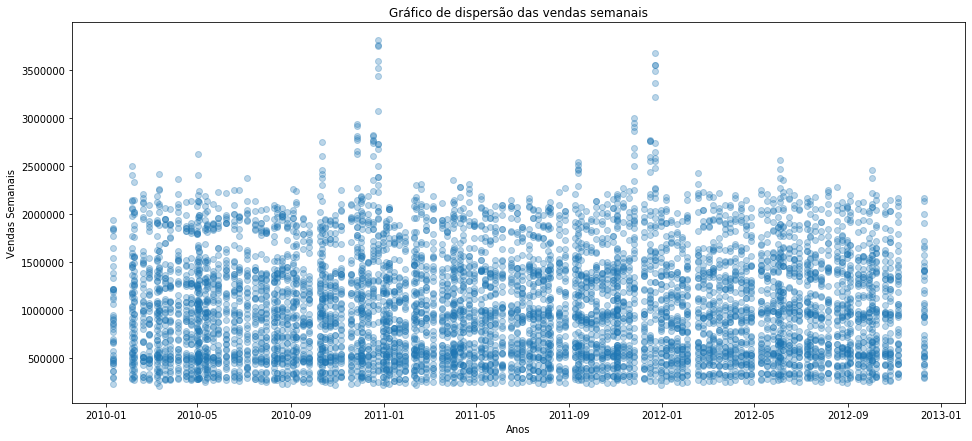

In [17]:
# Gráfico de dispersão das vendas semanais para todas as lojas ao longo do período 2010 a 2012

plt.figure(figsize=(16, 7))
plt.title('Gráfico de dispersão das vendas semanais')
plt.xlabel('Anos')
plt.ylabel('Vendas Semanais')
plt.plot(df.date, df.weeklysales, 'o', alpha=0.3)
plt.show()

Store 10, year 2012


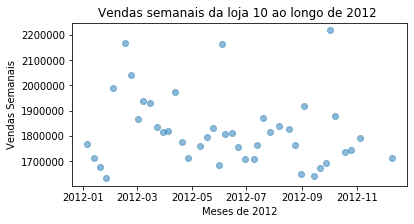

Store 44, year 2011


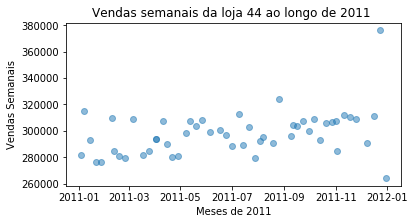

Store 13, year 2010


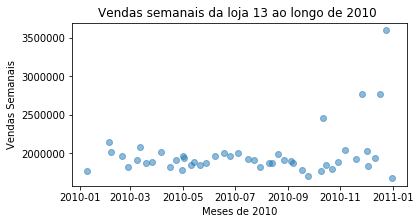

In [18]:
# Gráfico de dispersão das vendas semanais para lojas selecionadas aleatoriamente durante um ano selecionado
# também aleatoriamente

teste_lojas = []
teste_anos = []
for x in range(3):
    
    a = True # loop para não repetir loja e ano
    while a == True:
        n = random.randint(1,45)
        year = random.randint(2010,2012)
        if n not in teste_lojas and year not in teste_anos:
            teste_lojas.append(n)
            teste_anos.append(year)
            a = False
    
    filtroano = []
    for i in df.date:
        if i.year == year:
            filtroano.append(True)
        else:
            filtroano.append(False)
    
    filtrostore = df.store == str(n)
    
    datesano = []
    for i in range(len(df)):
        if df.date[i].year == year and df.store[i] == str(n):
            datesano.append(df.date[i])
    
    salesyear = df.loc[filtroano & filtrostore,'weeklysales']
    
    print(f'Store {n}, year {year}')
    plt.figure(figsize=(6, 3))
    plt.title('Vendas semanais da loja {0} ao longo de {1} '.format(n,year))
    plt.ylabel('Vendas Semanais')
    plt.xlabel('Meses de {0}'.format(year))
    plt.plot(datesano, salesyear,'o', alpha=0.5)
    plt.show()

* #### Análise descritiva detalhada das variáveis weeklysale e holiday:

In [19]:
# Análise da relação entre as variáveis weeklysales e holiday

no = df.holiday == 0
yes = df.holiday == 1

holiday_no = df.loc[no,["weeklysales"]]
holiday_yes = df.loc[yes,["weeklysales"]]

medidas_resumo_holiday_no = holiday_no.describe()
medidas_resumo_holiday_yes = holiday_yes.describe()

In [20]:
# Medidas resumo para semanas sem feriado

medidas_resumo_holiday_no.round(3)

,weeklysales
count,5985.000
mean,1041256.380
std,558957.436
min,209986.250
25%,551378.390
50%,956211.200
75%,1414343.530
max,3818686.450


In [21]:
# Medidas resumo para semanas com feriado

medidas_resumo_holiday_yes.round(3)

,weeklysales
count,450.000
mean,1122887.892
std,627684.932
min,215359.210
25%,575865.482
50%,1018538.040
75%,1555213.175
max,3004702.330


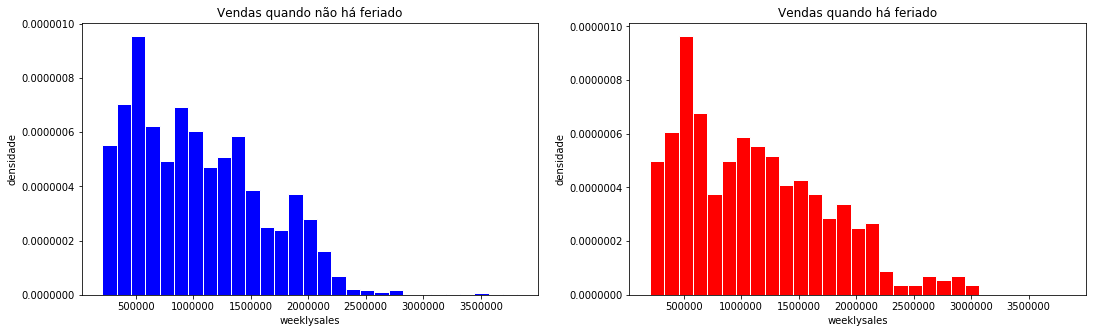

In [22]:
# Análise, em histograma, das vendas semanais para semanas em que não há ou não feriado

faixas = np.linspace(df.weeklysales.min(),df.weeklysales.max(),30)

plt.figure(figsize=(18, 5))

plt.subplot(121)
plt.hist(holiday_no.weeklysales, bins=faixas, density=True, color='blue', edgecolor='white')
plt.ylabel('densidade')
plt.xlabel('weeklysales')
plt.title('Vendas quando não há feriado')

plt.subplot(122)
plt.hist(holiday_yes.weeklysales, bins=faixas, density=True, color='red', edgecolor='white')
plt.ylabel('densidade')
plt.xlabel('weeklysales')
plt.title('Vendas quando há feriado')

plt.show()

* #### Análise geral das relações entre weeklysales e as demais variáveis

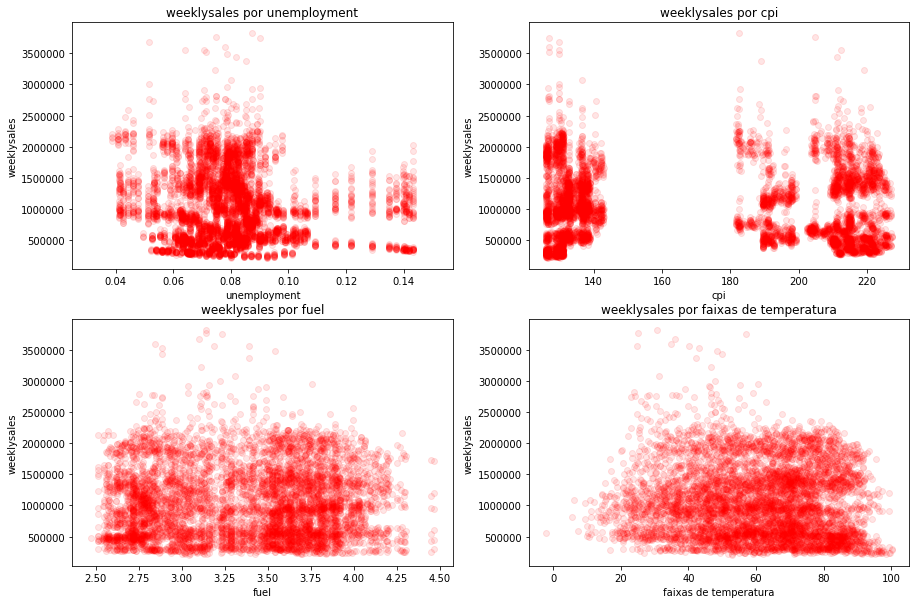

In [23]:
fig = plt.figure(figsize=(15,10))

# weeklysales com unemployment
plt.subplot(221)
plt.scatter(df.unemployment, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por unemployment')
plt.ylabel('weeklysales')
plt.xlabel('unemployment')

# weeklysales com cpi
plt.subplot(222)
plt.scatter(df.cpi, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por cpi')
plt.ylabel('weeklysales')
plt.xlabel('cpi')

# weeklysales com fuel
plt.subplot(223)
plt.scatter(df.fuel, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por fuel')
plt.ylabel('weeklysales')
plt.xlabel('fuel')

# weeklysales com temperature
plt.subplot(224)
plt.scatter(df.temperature, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por faixas de temperatura')
plt.ylabel('weeklysales')
plt.xlabel('faixas de temperatura')

plt.show()

In [24]:
# Correlações referentes às variáveis ilustradas nos gráficos acima

nomes = ['unemployment','cpi', 'fuel', 'temperature','holiday']
dfs = [df.unemployment, df.cpi, df.fuel, df.temperature, df.holiday]
for i in range(len(nomes)):
    print('Correlação entre {0} e weeklysales é: {1}'.format(nomes[i], df.weeklysales.corr(dfs[i])))

Correlação entre unemployment e weeklysales é: -0.10617608965795428
Correlação entre cpi e weeklysales é: -0.07263416204017631
Correlação entre fuel e weeklysales é: 0.009463786314475123
Correlação entre temperature e weeklysales é: -0.0638100131794696
Correlação entre holiday e weeklysales é: 0.03689096801041456


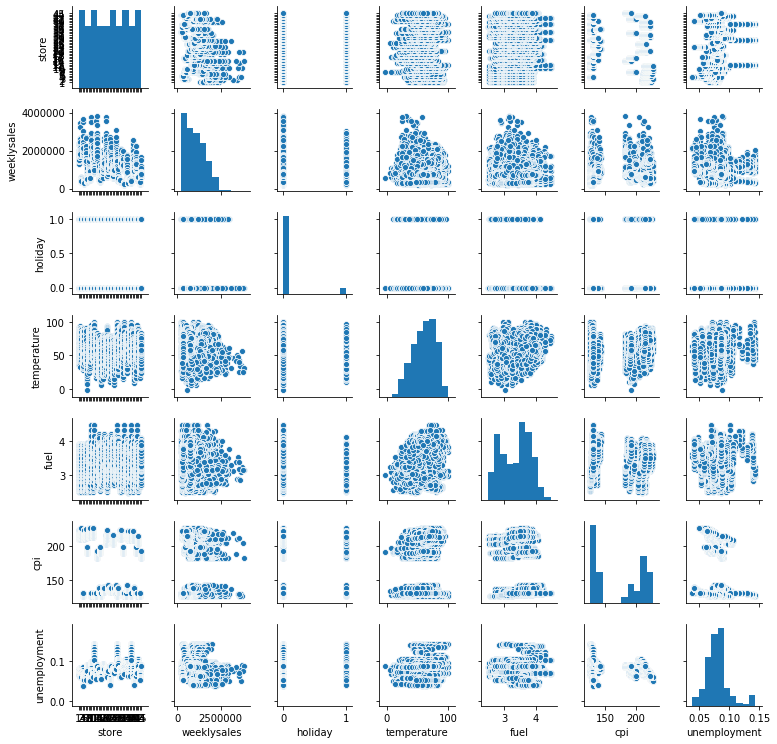

In [25]:
# Pairplot com as combinações de todas as variáveis quantitativas envolvidas

sns.pairplot(df, height=1.5);

## - Modelos de Predição -

* ### Separação da base de dados em conjuntos de treinamento e teste:

In [26]:
x = df.date.dt.year
df['year'] = pd.Series(x)
y = df.date.dt.month
df['month'] = pd.Series(y)
df

df.year = df.year.astype('int')
df.month = df.month.astype('int')

In [27]:
df.dtypes

store                 category
date            datetime64[ns]
weeklysales            float64
holiday                  int32
temperature            float64
fuel                   float64
cpi                    float64
unemployment           float64
year                     int32
month                    int32
dtype: object

In [28]:
df_shuffle = df.sample(frac = 1) 
df_treinamento = df_shuffle.head(int(len(df)*(0.75)+1))
df_teste = df_shuffle.tail(int(len(df)*(0.25)))

In [29]:
df_treinamento

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
1233,9,2011-10-21,557075.21,0,65.46,3.353,221.149821,0.06054,2011,10
6126,43,2012-05-25,597406.39,0,82.41,3.561,213.173668,0.09575,2012,5
103,1,2012-01-27,1319325.59,0,54.26,3.290,220.078852,0.07348,2012,1
1612,12,2010-05-11,929690.71,0,65.49,3.129,126.491290,0.14313,2010,5
4947,35,2011-09-23,705802.45,0,63.61,3.711,140.327250,0.08684,2011,9
...,...,...,...,...,...,...,...,...,...,...
2295,17,2010-03-26,793097.64,0,35.59,2.819,126.605064,0.06548,2010,3
6255,44,2012-02-17,320691.21,0,36.57,3.119,130.454621,0.05774,2012,2
2015,15,2010-07-05,661348.88,0,63.16,3.095,132.106200,0.08185,2010,7
4796,34,2011-07-29,851461.90,0,78.04,3.659,129.167710,0.10641,2011,7


In [30]:
df_teste

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
1285,9,2012-10-19,542009.46,0,68.01,3.594,227.214288,0.04954,2012,10
184,2,2010-11-19,1956739.17,0,50.81,2.771,211.547030,0.08163,2010,11
110,1,2012-03-16,1677472.78,0,64.74,3.734,221.211813,0.07348,2012,3
1087,8,2011-09-30,809049.37,0,72.20,3.355,220.132918,0.06425,2011,9
5694,40,2012-04-05,993311.59,0,44.47,3.991,138.033200,0.04125,2012,4
...,...,...,...,...,...,...,...,...,...,...
13,1,2010-07-05,1603955.12,0,72.55,2.835,210.339968,0.07808,2010,7
1701,12,2012-07-20,941550.34,0,85.53,3.726,130.701290,0.10926,2012,7
275,2,2012-08-17,1928016.01,0,84.79,3.571,221.675146,0.06565,2012,8
1007,8,2010-03-19,839911.00,0,47.26,2.720,214.576495,0.06299,2010,3


* ### 1° modelo: Regressão Linear Múltipla - adotando $α = 0,1\%$

* Hipóteses:

**H0: não há relação entre weeklysales e a variável analisada - $β = 0$**

**H1: há relação entre weeklysales e a variável analisada - $β ≠ 0$**

In [31]:
# Regressão linear múltipla para a combinação weeklysales com holiday, temperature, fuel, cpi, unemployment, year e
# month; todas as variáveis quantitativas.

x = df_treinamento[['holiday','temperature','fuel','cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

C:\Users\Dell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     20.02
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           1.21e-26
Time:                        23:26:21   Log-Likelihood:                -70722.
No. Observations:                4827   AIC:                         1.415e+05
Df Residuals:                    4819   BIC:                         1.415e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.261e+08   3.63e+07      3.476      0.001     5.5e+07    1.97e+08
holiday       3.328e+04   3.49e+04      0.953      0.341   -3.52e+04    1.02e+05
temperature   -803.2187    468.798     -1.713      0.087   -1722.276     115.839
fuel          9.251e+04   3.12e+04      2.964      0.003    3.13e+04    1.54e+05
cpi          -1172.1056    233.186     -5.026      0.000   -1629.257    -714.954
unemployment -4.395e+06   4.75e+05     -9.256      0.000   -5.33e+06   -3.46e+06
year          -6.21e+04   1.81e+04     -3.434      0.001   -9.76e+04   -2.66e+04
month         9557.0646   2617.355      3.651      0.000    4425.855    1.47e+04
==============================================================================
Omnibus:                      263.292   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.437
Skew:                           0.617   Prob(JB):                     1.74e-67
Kurtosis:                       2.915   Cond. No.                     9.11e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.11e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de holiday é muito maior do que o alpha adotado, então, como H0 não é rejeitado, conclui-se que não há relação significativa para o modelo entre weeklysales e holiday.

In [32]:
# Regressão linear múltipla para a combinação weeklysales com temperature, fuel, cpi, unemployment, year e month

x = df_treinamento[['temperature','fuel','cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     23.20
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           3.70e-27
Time:                        23:26:21   Log-Likelihood:                -70723.
No. Observations:                4827   AIC:                         1.415e+05
Df Residuals:                    4820   BIC:                         1.415e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.241e+08   3.62e+07      3.426      0.001    5.31e+07    1.95e+08
temperature   -881.5347    461.534     -1.910      0.056   -1786.352      23.283
fuel          9.066e+04   3.12e+04      2.910      0.004    2.96e+04    1.52e+05
cpi          -1167.7011    233.138     -5.009      0.000   -1624.759    -710.644
unemployment -4.367e+06   4.74e+05     -9.215      0.000    -5.3e+06   -3.44e+06
year         -6.108e+04   1.81e+04     -3.383      0.001   -9.65e+04   -2.57e+04
month         1.041e+04   2459.245      4.233      0.000    5589.546    1.52e+04
==============================================================================
Omnibus:                      263.872   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.129
Skew:                           0.617   Prob(JB):                     1.23e-67
Kurtosis:                       2.909   Cond. No.                     9.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de fuel é relativamente alta, então, a variável é desconsiderada da inferência.

In [33]:
# Regressão linear múltipla para a combinação weeklysales com temperature, cpi, unemployment, year e month

x = df_treinamento[['temperature', 'cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     26.11
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           4.15e-26
Time:                        23:26:21   Log-Likelihood:                -70727.
No. Observations:                4827   AIC:                         1.415e+05
Df Residuals:                    4821   BIC:                         1.415e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.874e+07   2.13e+07      1.821      0.069   -2.96e+06    8.04e+07
temperature   -622.3273    453.208     -1.373      0.170   -1510.822     266.167
cpi          -1400.2720    219.182     -6.389      0.000   -1829.969    -970.575
unemployment -4.185e+06    4.7e+05     -8.903      0.000   -5.11e+06   -3.26e+06
year         -1.848e+04   1.06e+04     -1.748      0.081   -3.92e+04    2249.382
month         1.104e+04   2451.544      4.504      0.000    6236.294    1.58e+04
==============================================================================
Omnibus:                      263.947   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.392
Skew:                           0.618   Prob(JB):                     1.08e-67
Kurtosis:                       2.919   Cond. No.                     5.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de year é maior do que o alpha adotado, então, como H0 não é rejeitado, conclui-se que não há relação significativa para o modelo entre weeklysales e year

In [34]:
# Regressão linear múltipla para a combinação weeklysales com cpi e unemployment

x = df_treinamento[['temperature', 'cpi','unemployment', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     31.86
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           3.05e-26
Time:                        23:26:21   Log-Likelihood:                -70728.
No. Observations:                4827   AIC:                         1.415e+05
Df Residuals:                    4822   BIC:                         1.415e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          1.57e+06   6.23e+04     25.182      0.000    1.45e+06    1.69e+06
temperature   -706.5227    450.736     -1.567      0.117   -1590.172     177.126
cpi          -1393.3695    219.193     -6.357      0.000   -1823.088    -963.651
unemployment -3.991e+06   4.57e+05     -8.735      0.000   -4.89e+06   -3.09e+06
month         1.168e+04   2424.527      4.819      0.000    6929.600    1.64e+04
==============================================================================
Omnibus:                      266.899   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              312.554
Skew:                           0.622   Prob(JB):                     1.35e-68
Kurtosis:                       2.931   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
# Regressão linear múltipla para a combinação weeklysales com cpi, unemployment e month

x = df_treinamento[['cpi','unemployment', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     41.65
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           1.45e-26
Time:                        23:26:21   Log-Likelihood:                -70730.
No. Observations:                4827   AIC:                         1.415e+05
Df Residuals:                    4823   BIC:                         1.415e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.551e+06   6.12e+04     25.348      0.000    1.43e+06    1.67e+06
cpi          -1468.0464    213.985     -6.860      0.000   -1887.556   -1048.537
unemployment -4.111e+06    4.5e+05     -9.129      0.000   -4.99e+06   -3.23e+06
month         1.142e+04   2419.123      4.721      0.000    6678.173    1.62e+04
==============================================================================
Omnibus:                      265.229   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              310.555
Skew:                           0.621   Prob(JB):                     3.66e-68
Kurtosis:                       2.964   Cond. No.                     9.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
# RMS - erro no treinamento
soma = 0
for resid in results.resid:
    soma += resid**2
RMS_0 = np.sqrt(soma/len(df_treinamento))
RMS_0

559046.3975338773

* Verificando as suposições do modelo de regressão linear:

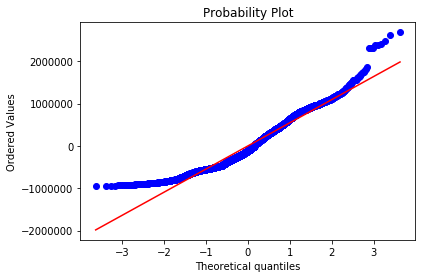

In [37]:
# Verificando a suposição de que os erros têm distribuição Normal

stats.probplot(results.resid, dist='norm', plot=plt);

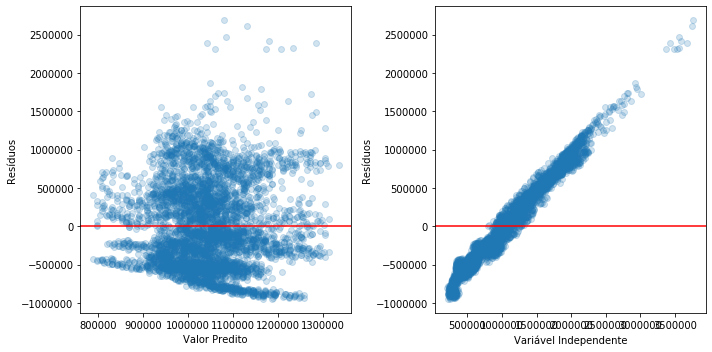

In [38]:
# Verificando a suposição de homocedasticidade:

fig = plt.figure(figsize = (10,5))

plt.subplot(121)
plt.scatter(results.predict(xc), results.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Valor Predito')

plt.subplot(122)
plt.scatter(y, results.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-'); # o valor da variável aleatórias está correto ?
plt.ylabel('Resíduos')
plt.xlabel('Variável Independente')

plt.tight_layout()
plt.show()

* Como evidenciado nos gráficos acima, as hipóteses do modelo não são seguidas. Dessa forma, afim de tentar ajustá-las, utilizou-se a escala logarítmica como ilustrado abaixo:

In [39]:
# Retira valores abaixo de 0

filtrotemperature1 = df_treinamento.temperature > 0
df_treinamento_log = df_treinamento.loc[filtrotemperature1,:]

filtrotemperature2 = df_teste.temperature > 0
df_teste_log = df_teste.loc[filtrotemperature2,:]

In [40]:
# Alterando a escala para log

df_treinamento_log.weeklysales = np.log(df_treinamento_log.weeklysales)
df_treinamento_log.temperature = np.log(df_treinamento_log.temperature)
df_treinamento_log.fuel = np.log(df_treinamento_log.fuel)
df_treinamento_log.cpi = np.log(df_treinamento_log.cpi)
df_treinamento_log.unemployment = np.log(df_treinamento_log.unemployment*100)
df_treinamento_log.month = np.log(df_treinamento_log.month)
df_treinamento_log.year = np.log(df_treinamento_log.year)
df_treinamento_log

C:\Users\Dell\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
1233,9,2011-10-21,13.230456,0,4.181439,1.209855,5.398840,1.800719,7.606387,2.302585
6126,43,2012-05-25,13.300353,0,4.411707,1.270041,5.362107,2.259156,7.606885,1.609438
103,1,2012-01-27,14.092631,0,3.993787,1.190888,5.393986,1.994428,7.606885,0.000000
1612,12,2010-05-11,13.742607,0,4.181897,1.140713,4.840173,2.661168,7.605890,1.609438
4947,35,2011-09-23,13.467091,0,4.152771,1.311301,4.943977,2.161482,7.606387,2.197225
...,...,...,...,...,...,...,...,...,...,...
2295,17,2010-03-26,13.583702,0,3.572065,1.036382,4.841073,1.879160,7.605890,1.098612
6255,44,2012-02-17,12.678234,0,3.599228,1.137512,4.871025,1.753365,7.606885,0.693147
2015,15,2010-07-05,13.402037,0,4.145671,1.129788,4.883606,2.102303,7.605890,1.945910
4796,34,2011-07-29,13.654710,0,4.357222,1.297190,4.861112,2.364714,7.606387,1.945910


In [41]:
df_teste_log.weeklysales = np.log(df_teste_log.weeklysales)
df_teste_log.temperature = np.log(df_teste_log.temperature)
df_teste_log.fuel = np.log(df_teste_log.fuel)
df_teste_log.cpi = np.log(df_teste_log.cpi)
df_teste_log.unemployment = np.log(df_teste_log.unemployment*100)
df_teste_log.month = np.log(df_teste_log.month)
df_teste_log.year = np.log(df_teste_log.year)
df_teste_log

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
1285,9,2012-10-19,13.203039,0,4.219655,1.279266,5.425894,1.600195,7.606885,2.302585
184,2,2010-11-19,14.486790,0,3.928093,1.019208,5.354447,2.099612,7.605890,2.397895
110,1,2012-03-16,14.332799,0,4.170379,1.317480,5.399121,1.994428,7.606885,1.098612
1087,8,2011-09-30,13.603615,0,4.279440,1.210452,5.394232,1.860197,7.606387,2.197225
5694,40,2012-04-05,13.808800,0,3.794815,1.384042,4.927494,1.417066,7.606885,1.386294
...,...,...,...,...,...,...,...,...,...,...
13,1,2010-07-05,14.287983,0,4.284276,1.042042,5.348725,2.055149,7.605890,1.945910
1701,12,2012-07-20,13.755283,0,4.448867,1.315335,4.872914,2.391145,7.606885,1.945910
275,2,2012-08-17,14.472002,0,4.440178,1.272846,5.401213,1.881753,7.606885,2.079442
1007,8,2010-03-19,13.641051,0,3.855664,1.000632,5.368666,1.840391,7.605890,1.098612


In [42]:
df_analise2 = df_treinamento_log[['weeklysales','temperature','fuel','cpi','unemployment', 'year', 'month']]
df_analise2.describe()

,weeklysales,temperature,fuel,cpi,unemployment,year,month
count,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000
mean,13.697437,4.047260,1.201955,5.118132,2.052072,7.606368,1.673421
std,0.591871,0.366282,0.139358,0.232967,0.224751,0.000395,0.690387
min,12.254797,1.711995,0.905028,4.836790,1.355577,7.605890,0.000000
25%,13.217095,3.865770,1.075344,4.880048,1.930216,7.605890,1.386294
50%,13.770133,4.137085,1.238954,5.207405,2.062550,7.606387,1.791759
75%,14.168046,4.315219,1.318551,5.360147,2.151181,7.606885,2.197225
max,15.141707,4.606569,1.496941,5.425975,2.661168,7.606885,2.484907


In [43]:
# Verificando se há valores indefinidos

df_analise2.isnull().sum()

weeklysales     0
temperature     0
fuel            0
cpi             0
unemployment    0
year            0
month           0
dtype: int64

In [44]:
logx =  df_treinamento_log[['temperature','fuel','cpi','unemployment', 'month', 'year']]
logy = df_treinamento_log['weeklysales']

logxc = sm.add_constant(logx)
logmodel = sm.OLS(logy,logxc)
logresults = logmodel.fit()
logresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     16.60
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           4.86e-19
Time:                        23:26:24   Log-Likelihood:                -4266.9
No. Observations:                4826   AIC:                             8548.
Df Residuals:                    4819   BIC:                             8593.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          915.7168    297.498      3.078      0.002     332.484    1498.950
temperature     -0.0954      0.025     -3.890      0.000      -0.144      -0.047
fuel             0.3432      0.110      3.128      0.002       0.128       0.558
cpi             -0.1474      0.041     -3.633      0.000      -0.227      -0.068
unemployment    -0.2714      0.041     -6.622      0.000      -0.352      -0.191
month            0.0416      0.013      3.277      0.001       0.017       0.066
year          -118.4276     39.129     -3.027      0.002    -195.138     -41.717
==============================================================================
Omnibus:                      457.310   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.101
Skew:                          -0.315   Prob(JB):                     4.79e-45
Kurtosis:                       2.214   Cond. No.                     3.73e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
logx =  df_treinamento_log[['temperature', 'cpi','unemployment', 'month']]
logy = df_treinamento_log['weeklysales']

logxc = sm.add_constant(logx)
logmodel = sm.OLS(logy,logxc)
logresults = logmodel.fit()
logresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     22.25
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           3.16e-18
Time:                        23:26:24   Log-Likelihood:                -4272.1
No. Observations:                4826   AIC:                             8554.
Df Residuals:                    4821   BIC:                             8587.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           15.4373      0.229     67.296      0.000      14.988      15.887
temperature     -0.0846      0.024     -3.523      0.000      -0.132      -0.038
cpi             -0.1910      0.038     -5.014      0.000      -0.266      -0.116
unemployment    -0.2442      0.039     -6.237      0.000      -0.321      -0.167
month            0.0484      0.012      3.890      0.000       0.024       0.073
==============================================================================
Omnibus:                      448.783   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.571
Skew:                          -0.315   Prob(JB):                     1.03e-44
Kurtosis:                       2.218   Cond. No.                         196.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# RMS log - erro no treinamento
soma = 0
for resid in logresults.resid:
    soma += resid**2
RMS_1 = np.sqrt(soma/len(df_treinamento_log))
RMS_1

0.5864218108813809

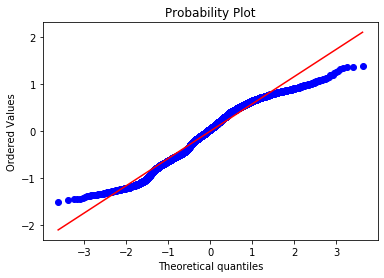

In [47]:
# Verificando a suposição de que os erros têm distribuição Normal

stats.probplot(logresults.resid, dist='norm', plot=plt);

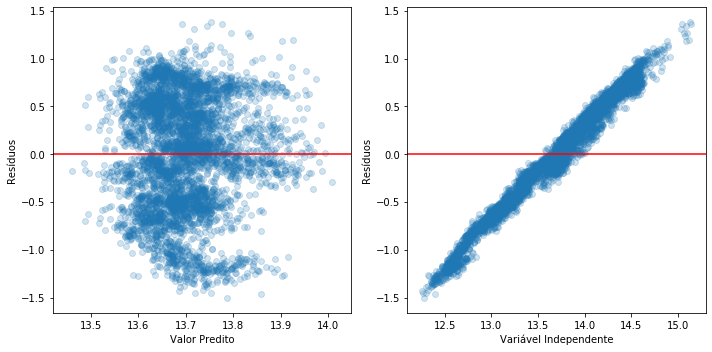

In [48]:
# Verificando a suposição de homocedasticidade na escala log:

fig = plt.figure(figsize = (10,5))

plt.subplot(121)
plt.scatter(logresults.predict(logxc), logresults.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Valor Predito')

plt.subplot(122)
plt.scatter(logy, logresults.resid, alpha=0.2); # o valor da variável aleatórias está correto ?
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Variável Independente')

plt.tight_layout()
plt.show()

* ### Modelo 2: Random Forest

In [49]:
from sklearn.model_selection import train_test_split

columns = df.columns.drop(['weeklysales', 'date'])
columns

Index(['store', 'holiday', 'temperature', 'fuel', 'cpi', 'unemployment',
       'year', 'month'],
      dtype='object')

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df[columns],df['weeklysales'], test_size=0.25)

In [51]:
tree_rf = RandomForestRegressor()

In [52]:
model_rf = tree_rf.fit(X_train, y_train)

resultado_rf = model_rf.predict(X_test)

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [53]:
mean_squared_error(y_test, resultado_rf)

22622419002.03466

In [54]:
model_rf.score(X_test,y_test)

0.928791615820175

In [55]:
from sklearn.model_selection import GridSearchCV # GridSearchCV faz teste exaustivamente encontrando os melhores parâmetros 

In [56]:
parametros = {'min_samples_leaf':[1,10],'min_samples_split':[2,10],'n_estimators':[100,250,500,750]} # parâmetros que queremos ajustar para melhorar

# valores mínimos de amostras para serem testadas na folha da árvore // valores mínimos de amostras para fazer a divisão do módulo interno, ajuda em deixar o modelo mais fluido. // árvores de decisão

In [57]:
rf = RandomForestRegressor() # qual regressão vou usar 
grid = GridSearchCV(rf, parametros)

In [58]:
grid.fit(X_train, y_train)

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': [1, 10

In [59]:
grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}

In [79]:
rf_best = grid.best_estimator_
resultado_final = rf_best.predict(X_test)
resultado_treinamento = rf_best.predict(X_train)

In [61]:
mean_squared_error(y_test, resultado_final)

20621210874.339

In [62]:
rf_best.score(X_test,y_test)

0.9350908005876362

In [63]:
rf_best.predict(X_test)


array([ 926464.6337842 , 1918590.72833666,  774248.62005328, ...,
        404101.09139258,  331835.88196577, 1027498.76272237])

## - Processo e Estatísticas de Validação -

In [64]:
# Função que calcula o r^2 da previsão do modelo pelos dados experimentais
def r_squared(dados, modelo):
    numerador = 0
    denominador = 0
    for i in range(len(modelo)):
        numerador += (dados[i]-modelo[i])**2
        denominador += (dados[i]-np.mean(dados))**2
    return 1 - numerador/denominador

##### Validação do modelo 1: Regressão Linear Múltipla

In [65]:
beta0_1 = results.params[0]
beta1_1 = results.params[1]
beta2_1 = results.params[2]
beta3_1 = results.params[3]

def f_modelo1(feature1, feature2, feature3):
    return beta0_1 + beta1_1*feature1 + beta2_1*feature2 + beta3_1*feature3

treinamento_1 = df_treinamento.weeklysales
predicoes_1_t = f_modelo1(df_treinamento.cpi, df_treinamento.unemployment, df_treinamento.month)
teste_1 = df_teste.weeklysales
predicoes_1 = f_modelo1(df_teste.cpi, df_teste.unemployment, df_teste.month)

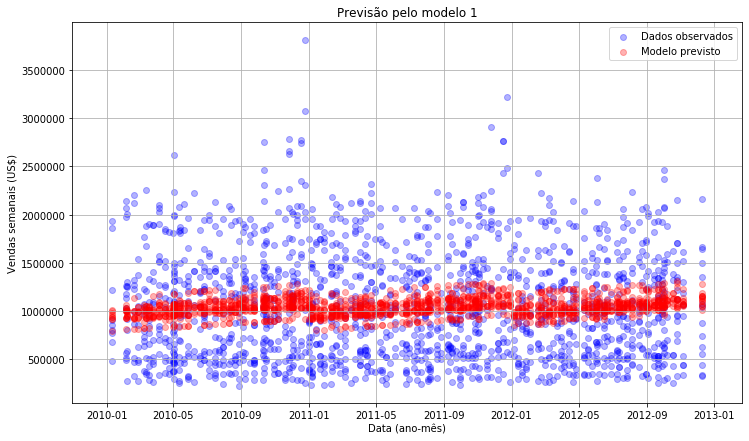

In [66]:
y_teste = df_teste.weeklysales
y_previsto = f_modelo1(df_teste.cpi, df_teste.unemployment, df_teste.month)
x = df_teste.date

plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 1')
plt.scatter(x, y_teste, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(x, y_previsto, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Data (ano-mês)')
plt.ylabel('Vendas semanais (US$)')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# RMSE no treinamento
soma = 0
for resid in results.resid:
    soma += resid**2
RMSE_modelo1_t = np.sqrt(soma/len(df_treinamento))
print(f'RMSE do modelo 1 (treinamento): {RMSE_modelo1_t:.5f}')

RMSE do modelo 1 (treinamento): 559046.39753


In [68]:
# RMSE no teste
residuos_1 = teste_1 - predicoes_1 #lista de residuos
soma = 0
for resid in residuos_1:
    soma += resid**2
RMSE_modelo1 = np.sqrt(soma/len(df_teste))
print(f'RMSE do modelo 1 (teste): {RMSE_modelo1:.5f}')

RMSE do modelo 1 (teste): 548587.92256


In [69]:
# r^2 entre o modelo previsto e os dados treinamento
r_sqr_1_t = r_squared(list(treinamento_1),list(predicoes_1_t))
print(f'r^2 do modelo 1 (treinamento): {r_sqr_1_t:.5f}')

r^2 do modelo 1 (treinamento): 0.02525


In [70]:
# r^2 entre o modelo previsto e os dados teste
r_sqr_1 = r_squared(list(teste_1),list(predicoes_1))
print(f'r^2 do modelo 1 (teste): {r_sqr_1:.5f}')

r^2 do modelo 1 (teste): 0.03497


##### Validação do modelo 1 com escala logarítmica

In [71]:
beta0_1_log = logresults.params[0]
beta1_1_log = logresults.params[1]
beta2_1_log = logresults.params[2]
beta3_1_log = logresults.params[3]
beta4_1_log = logresults.params[4]

def f_modelo1_log(feature1, feature2, feature3, feature4): # função que prevê, dados os features, um valor previsto para weeklysales
    return beta0_1_log + beta1_1_log*feature1 + beta2_1_log*feature2 + beta3_1_log*feature3 + beta4_1_log*feature4

treinamento_1_log = df_treinamento_log.weeklysales
predicoes_1_log_t = f_modelo1_log(df_treinamento_log.temperature, df_treinamento_log.cpi, df_treinamento_log.unemployment, df_treinamento_log.month)
teste_1_log = df_teste_log.weeklysales
predicoes_1_log = f_modelo1_log(df_teste_log.temperature, df_teste_log.cpi, df_teste_log.unemployment, df_teste_log.month)

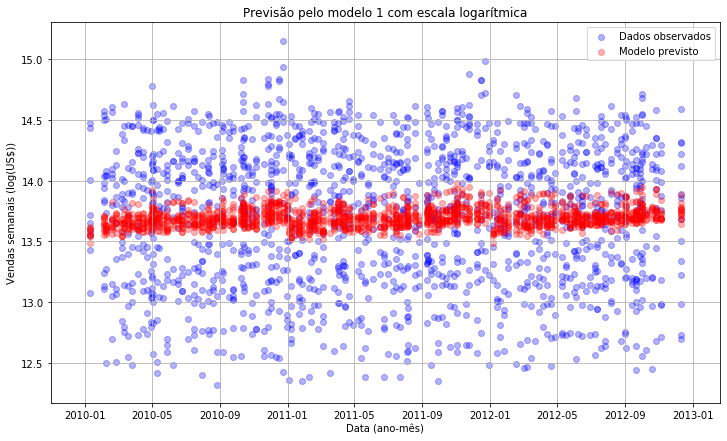

In [72]:
y_teste_log = df_teste_log.weeklysales
y_previsto_log = f_modelo1_log(df_teste_log.temperature, df_teste_log.cpi, df_teste_log.unemployment, df_teste_log.month)
x_log = df_teste_log.date

plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 1 com escala logarítmica')
plt.scatter(x_log, y_teste_log, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(x_log, y_previsto_log, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Data (ano-mês)')
plt.ylabel('Vendas semanais (log(US$))')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
# RMSE (log) no treinamento
soma = 0
for resid in logresults.resid:
    soma += resid**2
RMSE_modelo1_log_t = np.sqrt(soma/len(df_treinamento_log))
print(f'RMSE do modelo 1 com escala logarítmica (treinamento): {RMSE_modelo1_log_t:.5f}')

RMSE do modelo 1 com escala logarítmica (treinamento): 0.58642


In [74]:
# RMSE (log) no teste
residuos_1_log = teste_1_log - predicoes_1_log #lista de residuos
soma = 0
for resid in residuos_1_log:
    soma += resid**2
RMSE_modelo1_log = np.sqrt(soma/len(df_teste_log))
print(f'RMSE do modelo 1 com escala logarítmica (teste): {RMSE_modelo1_log:.5f}')

RMSE do modelo 1 com escala logarítmica (teste): 0.56923


In [75]:
# r^2 entre o modelo previsto e os dados treinamento
r_sqr_1_log_t = r_squared(list(treinamento_1_log),list(predicoes_1_log_t))
print(f'r^2 do modelo 1 com escala logarítmica: {r_sqr_1_log_t:.5f}')

r^2 do modelo 1 com escala logarítmica: 0.01813


In [76]:
# r^2 entre o modelo previsto e os dados teste
r_sqr_1_log = r_squared(list(teste_1_log),list(predicoes_1_log))
print(f'r^2 do modelo 1 com escala logarítmica: {r_sqr_1_log:.5f}')

r^2 do modelo 1 com escala logarítmica: 0.02779


##### Validação do modelo 2: Random Forest Regression

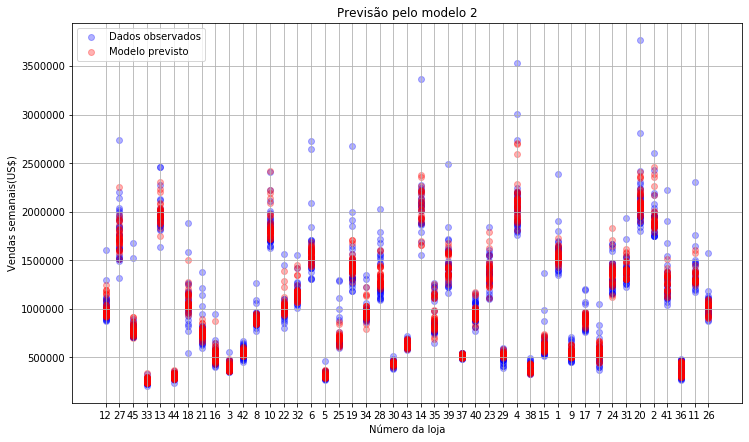

In [77]:
plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 2')
plt.scatter(X_test.store, y_test, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(X_test.store, resultado_final, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Número da loja')
plt.ylabel('Vendas semanais(US$)')
plt.legend()
plt.grid(True);

In [80]:
# RMSE para treinamento
treinamento_2 = y_train
predicoes_2_t = resultado_treinamento
residuos_2_t = treinamento_2 - predicoes_2_t #lista de residuos
soma = 0
for resid in residuos_2_t:
    soma += resid**2
RMSE_modelo2_t = np.sqrt(soma/len(y_train))
print(f'RMSE do modelo 2 (treinamento): {RMSE_modelo2_t:.5f}')

RMSE do modelo 2 (treinamento): 90949.82947


In [81]:
# RMSE para teste
teste_2 = y_test
predicoes_2 = resultado_final
residuos_2 = teste_2 - predicoes_2 #lista de residuos
soma = 0
for resid in residuos_2:
    soma += resid**2
RMSE_modelo2 = np.sqrt(soma/len(y_test))
print(f'RMSE do modelo 2 (teste): {RMSE_modelo2:.5f}')

RMSE do modelo 2 (teste): 143600.87352


In [82]:
# r^2 para treinamento
r_sqr_2_t = r_squared(list(treinamento_2),list(predicoes_2_t))
print(f'r^2 do modelo 2 (treinamento): {r_sqr_2_t:.5f}')

r^2 do modelo 2 (treinamento): 0.97404


In [83]:
# r^2 para teste
r_sqr_2 = r_squared(list(teste_2),list(predicoes_2))
print(f'r^2 do modelo 2 (teste): {r_sqr_2:.5f}')

r^2 do modelo 2 (teste): 0.93509


In [84]:
RMSEs = pd.Series([RMSE_modelo1_t, RMSE_modelo1, RMSE_modelo1_log_t, RMSE_modelo1_log, RMSE_modelo2_t, RMSE_modelo2])
r_sqrs = pd.Series([r_sqr_1_t, r_sqr_1, r_sqr_1_log_t, r_sqr_1_log, r_sqr_2_t, r_sqr_2])
indexes = pd.Series(['Modelo 1 - treinamento', 'Modelo 1 - teste', 'Modelo 1 (log) - treinamento', 'Modelo 1 (log) - teste', 'Modelo 2 - treinamento', 'Modelo 2 - teste'])
compare = pd.DataFrame()
compare['Modelos'] = indexes
compare['RMSE'] = RMSEs
compare['R^2'] = r_sqrs
compare

,Modelos,RMSE,R^2
0,Modelo 1 - treinamento,559046.397534,0.025253
1,Modelo 1 - teste,548587.922557,0.034965
2,Modelo 1 (log) - treinamento,0.586422,0.018127
3,Modelo 1 (log) - teste,0.569232,0.027792
4,Modelo 2 - treinamento,90949.829473,0.974042
5,Modelo 2 - teste,143600.873515,0.935091


#### Tentativa de modelo - Janelas deslizantes 

In [85]:
# Se estiver utilizando um software offline, biblioteca plotly deve ser instalada com o seguinte comando no terminal:
# pip install plotly==4.12.0
import plotly
import plotly.offline as py
from plotly.offline import plot, iplot
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)


# Define uma variável chamada Y que é a cópia da série de dados:
Y = df_teste.sort_values('date').weeklysales

# Define a variável window = 2 que será a janela de 2 valores:
window = 2

# Obtém os 2 primeiros valores da série:
history = []
for i in range(window):
    history.append(Y.iloc[i])

# Obtém todos os valores após os 2 primeiros:
teste_j = []
for i in range(window, len(Y)):
    teste_j.append(Y.iloc[i])

# Cria lista de predições:
predicoes_j = []

# Percorre sobre os dados de treinamento...

for t in range(len(teste_j)):
    # Define a variável length com o tamanho da variável history:
    length = len(history)
    
    # Define a variável valor_predito com a média dos 2 valores correntes..
    valor_predito = []
    for i in range(length - window, length):
        valor_predito.append(history[i])
    valor_predito = np.mean(valor_predito)
    
    # Define a variável valor_real com o valor atual do teste..
    valor_real = teste_k[t]
    
    # Alimenta a lista de predições:
    predicoes_j.append(valor_predito)
    # Atualiza a lista history com os valores correntes..
    history.append(valor_real)
    

# Calcula a métrica de rms:
rms_j = np.sqrt(mean_squared_error(teste_j, predicoes_j))
# Imprime o valor de rms:
print('RMS desse modelo: %.3f' % rms_j)

r_sqr_j = r_squared(list(teste_j),list(predicoes_j))
print(f'r quadrado do modelo de médias móveis: {r_sqr_j:.5f}')

indices = [i for i in range(0, int(len(teste_j)))]
teste = go.Scatter(x=indices,y=teste_j,name = "Conjunto de teste",line = dict(color = '#330000'),opacity = 0.8)
MM_2 = go.Scatter(x=indices,y=predicoes_j,name = "Média Móvel 2 Períodos",line = dict(color = '#FF00FF'),opacity = 0.8)
data = [teste, MM_2]
layout = dict(title = "Teste set vs Média Móvel 2 períodos",title_x= 0.5)
fig = dict(data=data, layout=layout)
py.iplot(fig)

ModuleNotFoundError: No module named 'plotly'